# Trabalho 2

Grupo 5  
Filipe Barbosa a77252  
Hugo Ferreira a78555  

In [1]:
import networkx as nx
import random
from z3 import *

### Problema 1

#### 1.a. Gerar aleatoriamente o grafo.

Assume-se $N$ para o número de nodos e $D$ sendo o número máximo de descendentes de cada nodo.

Definimos então a função que vai gerar um grafo aleatório.  

Começa-se por inicializar um grafo orientado vazio, recorrendo à biblioteca networkx.

Em seguida percorremos todos os nodos e definimos o número de descedentes, daquele nodo particular, aleatoriamente no intervalo de $1$ a $D$ e geramos aleatóriamente o nodo ao qual se vai ligar. Em caso de já existir essa aresta ou os dois nodos serem iguais, geramos um nodo novo. e adicionamos ao grafo $graph$.


In [2]:
N = 15
D = 5

def gerar_graph():
    graph = nx.DiGraph()
    # criar ligação aos descendentes para cada nodo
    for x in range(1,N+1):
        # gerar aleatoriamente o numero de descendentes
        nd = random.randint(1,D)
        # criar as arestas para os descendentes
        for i in range(nd):
            y=random.randint(1,N)
            while(graph.has_edge(x,y) or y==x):
                y=random.randint(1,N)
            graph.add_edge(x,y)
    
    return graph

Começamos por invocar a função acima criada.  

Em seguida, vamos testar se o grafo gerado é conectado, e em caso de não ser continuamos a gerar um grafo até ser.  

Finalmente, desenhamos o grafo orientado ligado.

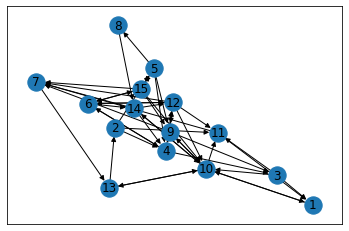

In [3]:
graph = gerar_graph()

# caso o grafo não seja orientado gera-se novamente
while(nx.is_strongly_connected(graph)!=True):
    graph = gerar_graph()

pos = nx.spring_layout(graph)
nx.draw_networkx(graph, pos)

#### 1.b. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

Começamos por definir a função remove_max que cria o Solver e inicializa a matriz de alocação com as arestas do grafo sendo estas $0$ ou $1$. Em caso do valor da aresta ser $1$ significa que esta vai pertencer ao grafo final, caso seja $0$ é porque não pertence.  

Depois adicionamos as fórmulas seguintes ao Solver:

Cada nodo $i$ esta conectado no mínimo um nodo $j$, ou seja, todos os vertices têm de estar ligados a pelo menos outro.
$$
\sum_{i} \sum_{j} x_{i,j} \geq 1
\tag 1
$$

Cada nodo $j$ tem no mínimo um nodo $i$ conectado a si, ou seja, todos os vertices tem outro que liga-se a si.
$$
\sum_{j} \sum_{i} x_{i,j} \geq 1
\tag 2
$$

Por cada par de vértices $(i,j)$ enumeramos todos os caminhos dado pelo $P$,que neste caso é a função $path\_edges$. Usamos a condição $Or$ do $Z3$ para condicionar que o somatório de um dos caminhos é igual ao tamanho do caminho. 
$$
\forall_{i,j} \in V \bigvee_{p \in P_{i,j}} \sum_{i,j} d_{i,j} == |p|
\tag 3
$$

Criamos a variável $obj$ sendo esta o somatório de todas as arestas contidas na matriz alocação. Usamos esta variável para depois darmos como argumento ao $minimize$. Este $minimize$ faz com que resultado do somatório $obj$ seja o menor possível que satifaça a condição $(1)$, a condição $(2)$ e a condição $(3)$ para ficar no grafo o número minimo de arestas mantendo o gráfo ligado.

Em seguida fazemos o check do $sol$ em caso de este ser $sat$ usamos a função $create\_new\_graph$ que usando uma matriz e um modelo cria um grafo.   

Finalmente desenhamos o grafo final que contem apenas o número de arestas minimo para que seja ligado.

Foram removidos  33 [(10, 1), (10, 13), (10, 14), (10, 9), (2, 5), (2, 11), (4, 12), (4, 3), (5, 15), (5, 9), (5, 4), (11, 1), (3, 11), (3, 10), (12, 7), (12, 11), (12, 6), (12, 10), (6, 4), (6, 12), (6, 14), (15, 6), (15, 7), (15, 10), (15, 9), (9, 7), (9, 10), (9, 4), (9, 12), (14, 10), (14, 7), (14, 4), (13, 10)] caminhos


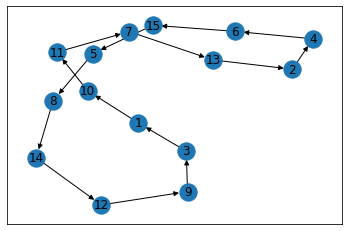

In [4]:
# dá caminhos entre elementos dados numa lista
def path_edges(path):
    return [(path[i],path[i+1]) for i in range(len(path)-1)]
        
# remove o maximo de arestas possiveis
def remove_max(graph):
    sol = Optimize()
    
    d = {}
    
    for e in graph.edges():
        d[e] = Int(str(e))
        sol.add(d[e] >= 0, d[e] <= 1)
        
    # Fórmula (1)
    for v in graph:
        l=graph.out_edges(v)
        sol.add(Sum([d[(a,b)] for a,b in l]) >= 1)
    
    # Fórmula (2)
    for v in graph:
        l=graph.in_edges(v)
        sol.add(Sum([d[(a,b)] for a,b in l]) >= 1)
    
    # Fórmula (3)    
    for v in graph:
        for i in graph:
            if(v!=i):
                l=[]
                for p in nx.all_simple_paths(graph,v,i):
                    l.append(Sum([d[e] for e in path_edges(p)])==len(path_edges(p)))
                tup=tuple(l)
                sol.add(Or(tup))
      
    # somatorio de todas as arestas no matriz de alocação
    obj = Sum([d[e] for e in graph.edges()])
    
    # minimize para ficarem o menor número de arestas mantendo o grafo ligado
    sol.minimize(obj)
    
    if sol.check() == sat:
        m = sol.model()
        graphD = create_new_graph(m,d)
        r=int(len(graph.edges()))-int(str(m.eval(obj)))
        print("Foram removidos ",str(r), [e for e in graph.edges() if m[d[e]] == 0],"caminhos")
        pos = nx.spring_layout(graphD)
        nx.draw_networkx(graphD, pos)

    
# cria um grafo novo
def create_new_graph(m,d):
    graphD = nx.DiGraph()
    for e in graph.edges():
        if m[d[e]]==1:
            a,b = e
            graphD.add_edge(a,b)
    return graphD

remove_max(graph)

#### Análise do tempo de execução

Para o $N=32$ a nossa resolução não dá o resultado em tempo útil.
Notamos que a partir $N=20$ o tempo de execução, dependendo dos descendentes que cada vertice tem (número dado aleatoriamente num intervalo entre 1 e 5), torna a solução não agradável.
A relação entre o aumento do número de nodos e o tempo de execução leva-nos a crer que a solução executa em tempo exponencial.